In [1]:
!pip install squarify category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.6 MB/s eta 0:00:00


In [2]:
# Основные библиотеки
import pandas as pd
import numpy as np
from scipy import stats
import random
import warnings

# Библиотеки визуализации
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import squarify
%matplotlib inline

# Библиотеки машинного обучения
from category_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# random seed
rs = 42

In [3]:
data = pd.read_csv('Student Depression Dataset.csv')

In [4]:
data.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [5]:
data.shape

(27901, 18)

Данные имеют информацию по 27901 строк и с 18 признаков.  

target - *Depression*

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

Единственная колонка с пропущенными значениями — Financial Stress (3 пропущенных значения). Этот объем невелик и его можно обработать.

In [7]:
print("Проверка на наличие пропущенных значений в каждом столбце:")
print(data.isnull().sum())

Проверка на наличие пропущенных значений в каждом столбце:
id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64


In [8]:
# Проверка на основные статистики
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,27901.0,NaN,NaN,NaN,70442.149421,40641.175216,2.0,35039.0,70684.0,105818.0,140699.0
Gender,27901,2,Male,15547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,27901.0,NaN,NaN,NaN,25.8223,4.905687,18.0,21.0,25.0,30.0,59.0
City,27901,52,Kalyan,1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profession,27901,14,Student,27870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Academic Pressure,27901.0,NaN,NaN,NaN,3.141214,1.381465,0.0,2.0,3.0,4.0,5.0
Work Pressure,27901.0,NaN,NaN,NaN,0.00043,0.043992,0.0,0.0,0.0,0.0,5.0
CGPA,27901.0,NaN,NaN,NaN,7.656104,1.470707,0.0,6.29,7.77,8.92,10.0
Study Satisfaction,27901.0,NaN,NaN,NaN,2.943837,1.361148,0.0,2.0,3.0,4.0,5.0
Job Satisfaction,27901.0,NaN,NaN,NaN,0.000681,0.044394,0.0,0.0,0.0,0.0,4.0


Age: от 18 до 59 лет, средний возраст ~26 лет.  
CGPA: успеваемость от 0 до 10, среднее около 7.66.  

Целевая переменная (Depression): бинарная (0 или 1), среднее значение ~0.585, что указывает на высокий процент депрессии в выборке.

In [9]:
print("В наборе данных есть {} дубликатов.".format(data.duplicated().sum()))

В наборе данных есть 0 дубликатов.


In [10]:
# Удалим столбец "id" в наборах данных
data = data.drop(['id'], axis=1)

# Определим целевой столбец
target_column = 'Depression'

# Выберим категориальные и числовые столбцы
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(exclude=['object']).columns.drop(target_column)

print("Целевая колонка:", target_column)
print("\nКатегориальные колонки:", categorical_columns.tolist())
print("\nЧисловые колонки:", numerical_columns.tolist())

Целевая колонка: Depression

Категориальные колонки: ['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Числовые колонки: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']


In [11]:
for column in categorical_columns:
    num_unique = data[column].nunique()
    print(f"'{column}' имеет {num_unique} уникальные категории.")

'Gender' имеет 2 уникальные категории.
'City' имеет 52 уникальные категории.
'Profession' имеет 14 уникальные категории.
'Sleep Duration' имеет 5 уникальные категории.
'Dietary Habits' имеет 4 уникальные категории.
'Degree' имеет 28 уникальные категории.
'Have you ever had suicidal thoughts ?' имеет 2 уникальные категории.
'Family History of Mental Illness' имеет 2 уникальные категории.


In [12]:
# Выведим топ 10 наибольшее колич уникальных значений для каждого категориального столбца
for column in categorical_columns:
    print(f"\nНаибольшее значение имеет '{column}':\n{data[column].value_counts().head(10)}")


Наибольшее значение имеет 'Gender':
Gender
Male      15547
Female    12354
Name: count, dtype: int64

Наибольшее значение имеет 'City':
City
Kalyan         1570
Srinagar       1372
Hyderabad      1340
Vasai-Virar    1290
Lucknow        1155
Thane          1139
Ludhiana       1111
Agra           1094
Surat          1078
Kolkata        1066
Name: count, dtype: int64

Наибольшее значение имеет 'Profession':
Profession
Student             27870
Architect               8
Teacher                 6
Digital Marketer        3
Content Writer          2
Chef                    2
Doctor                  2
Pharmacist              2
Civil Engineer          1
UX/UI Designer          1
Name: count, dtype: int64

Наибольшее значение имеет 'Sleep Duration':
Sleep Duration
Less than 5 hours    8310
7-8 hours            7346
5-6 hours            6183
More than 8 hours    6044
Others                 18
Name: count, dtype: int64

Наибольшее значение имеет 'Dietary Habits':
Dietary Habits
Unhealthy    10317

# 2. Exploratory Data Analysis (EDA)

## 2.1 Распределение числовых переменных

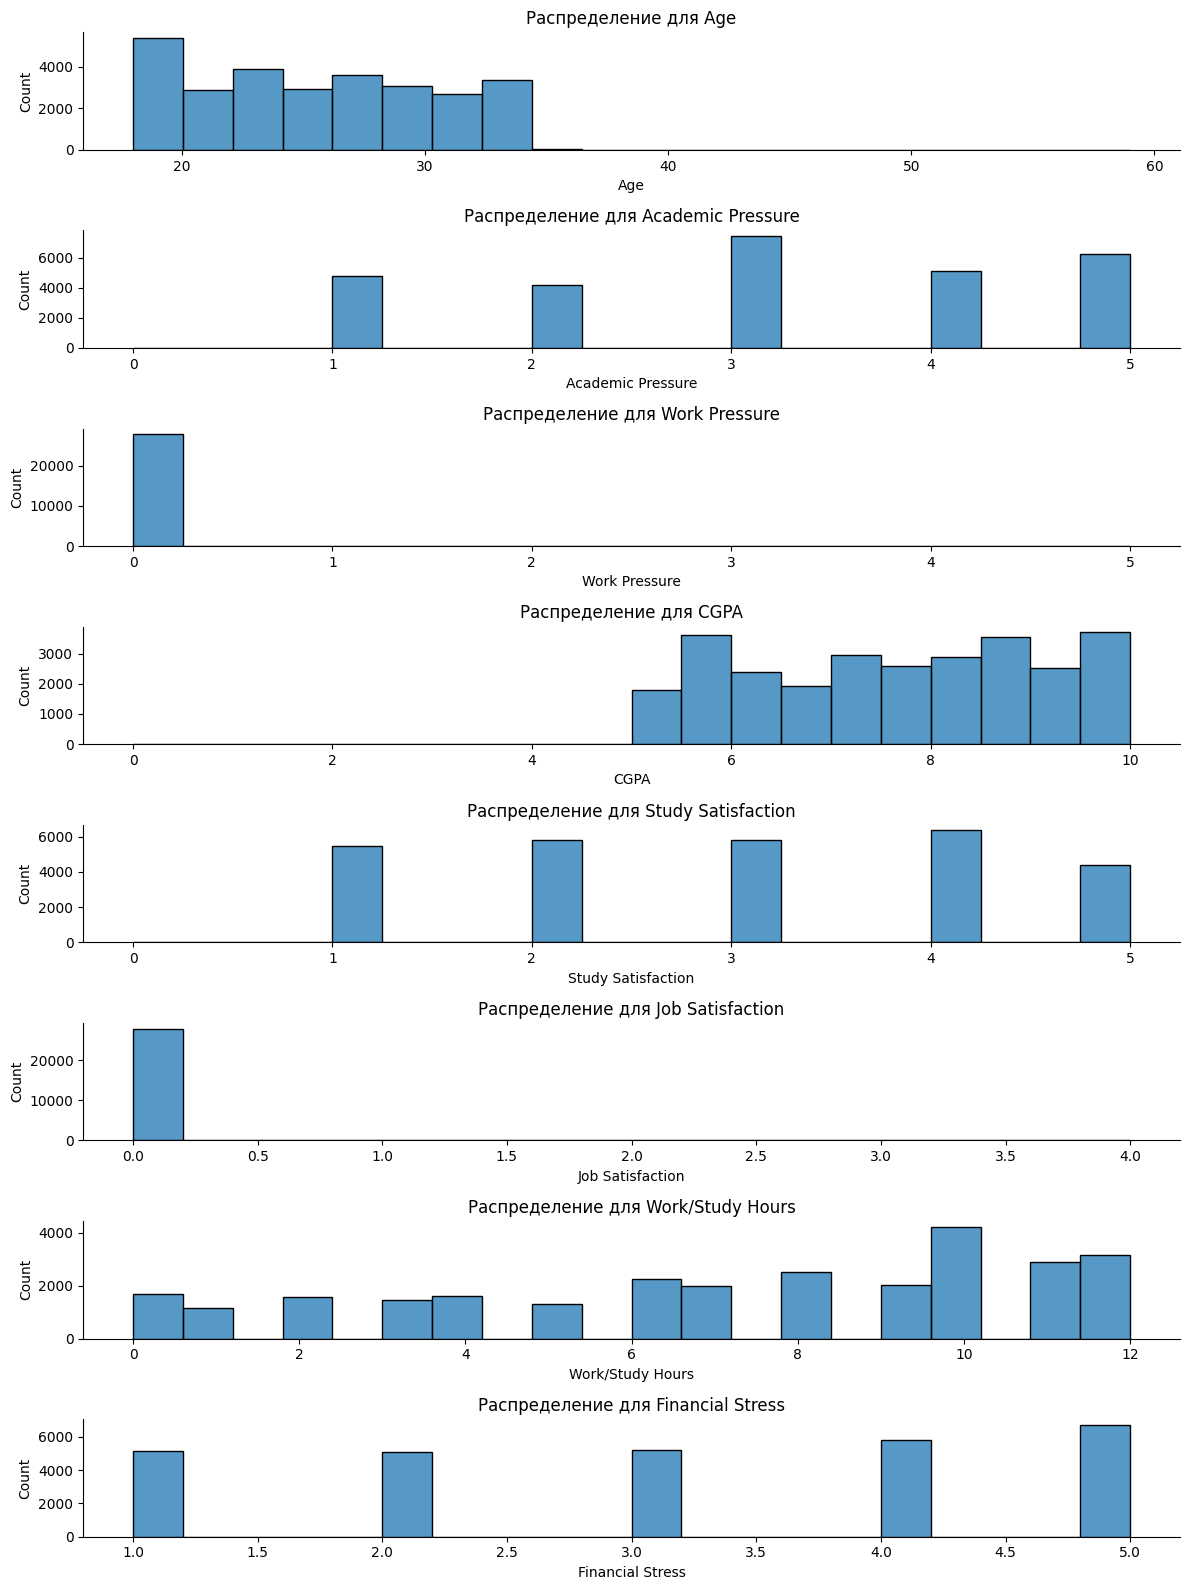

In [26]:
plt.figure(figsize=(12, 16))

for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i+1)
    sns.histplot(data=data, x=column, kde=False, bins=20)
    plt.title(f'Распределение для {column}')
    sns.despine()

plt.tight_layout()
plt.show()

## 2.2 Распределение категориальных признаков

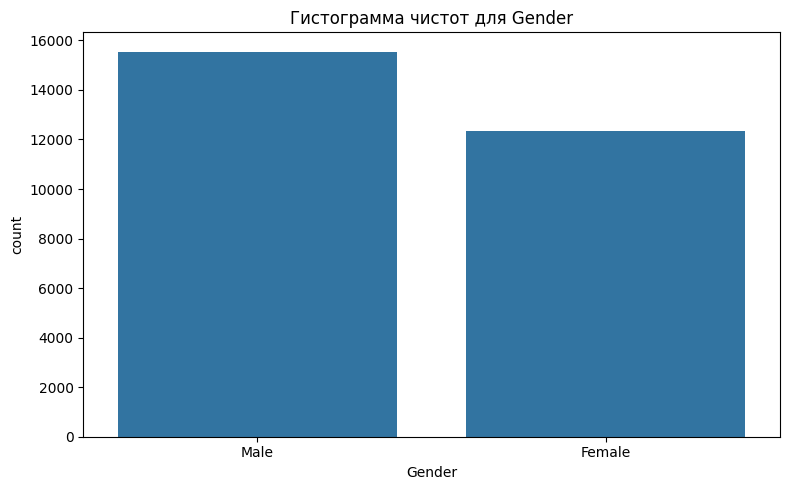

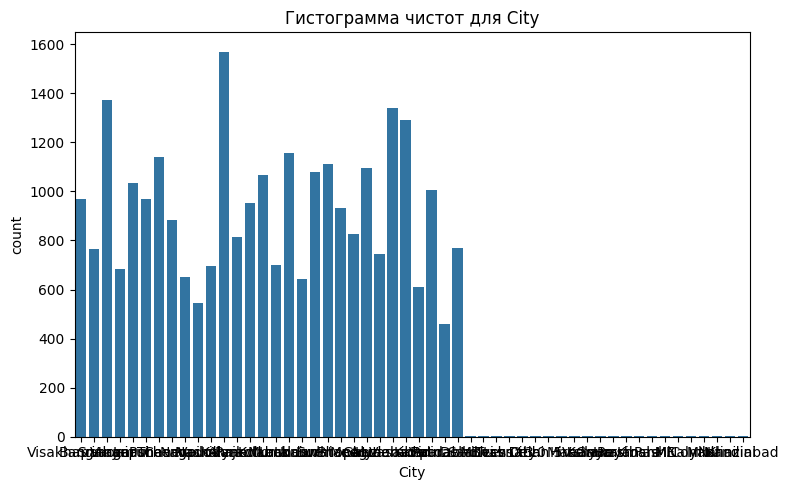

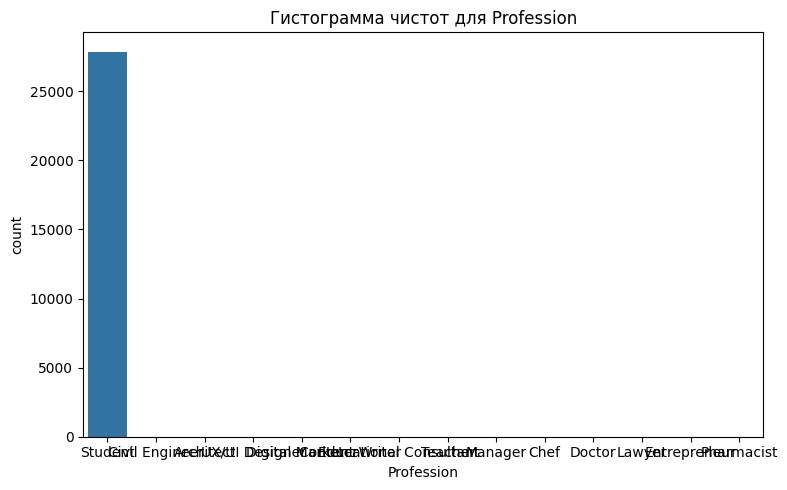

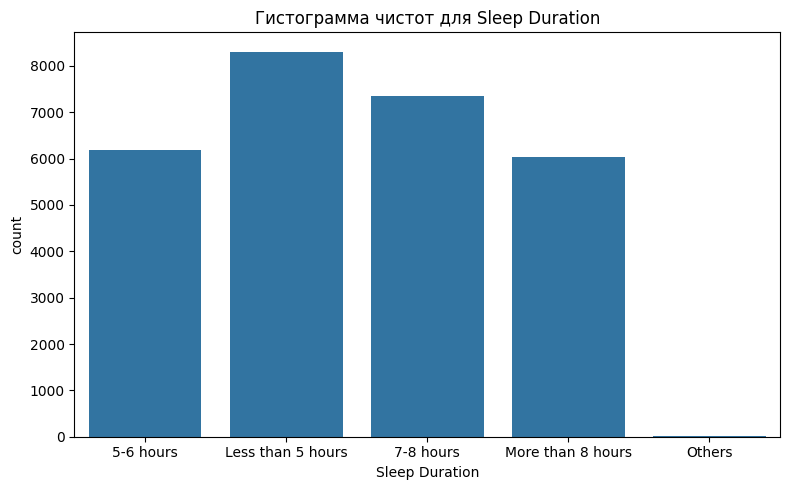

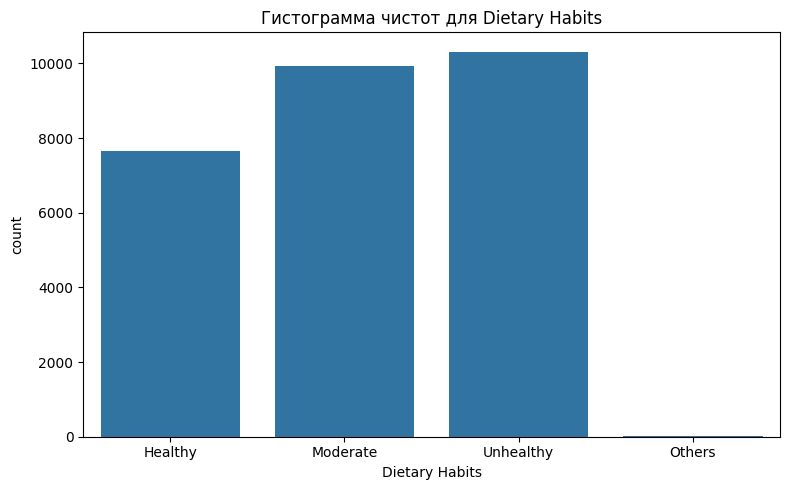

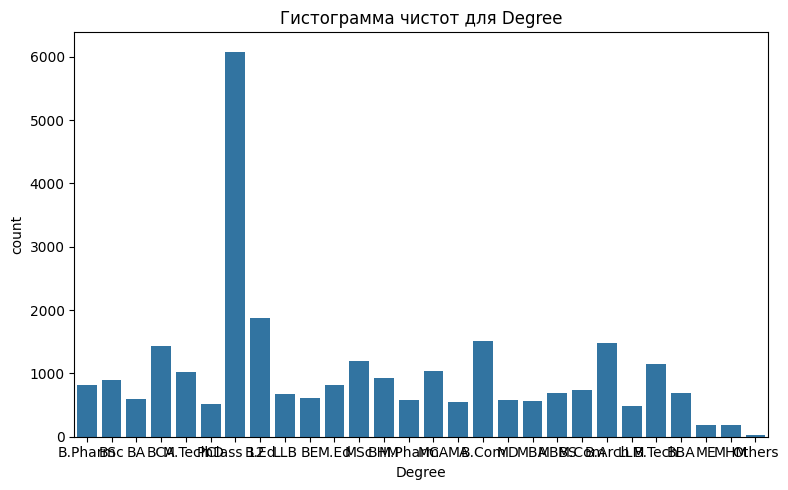

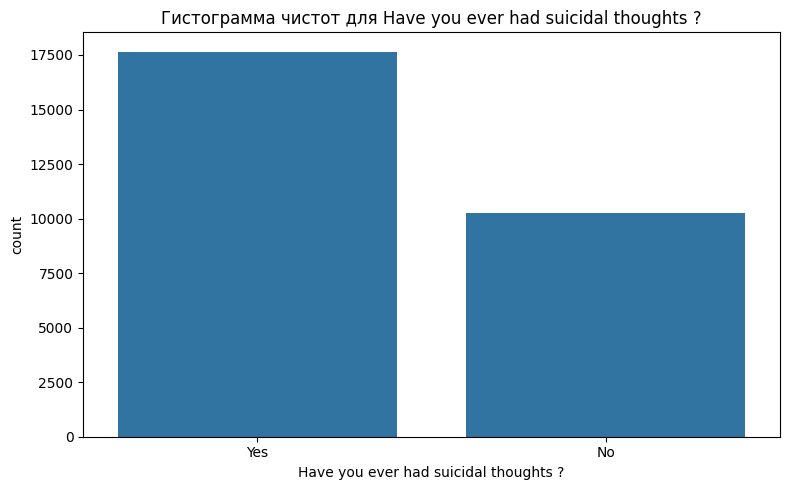

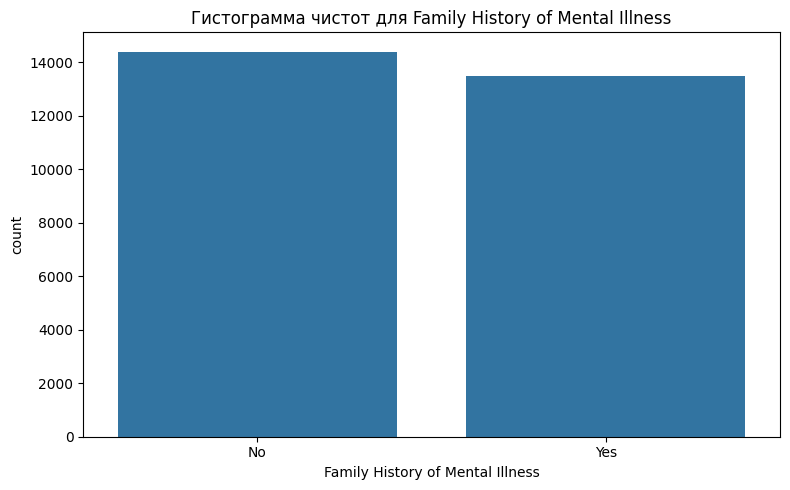

In [27]:
# Постройм графики для каждого категориального столбца
for column in categorical_columns:

    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=column)
    plt.title(f'Гистограмма чистот для {column}')

    plt.tight_layout()
    plt.show()

## 2.3 Распределение числовых характеристик в зависимости от наличия депрессии

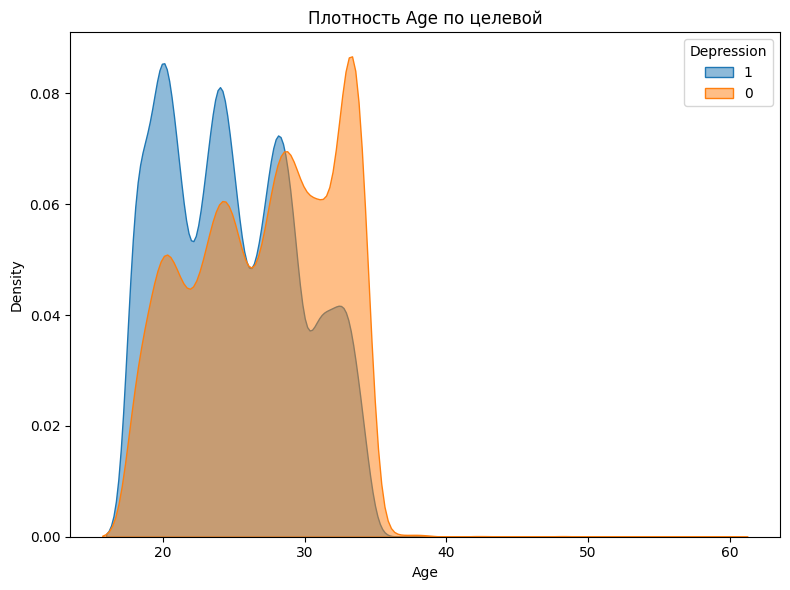

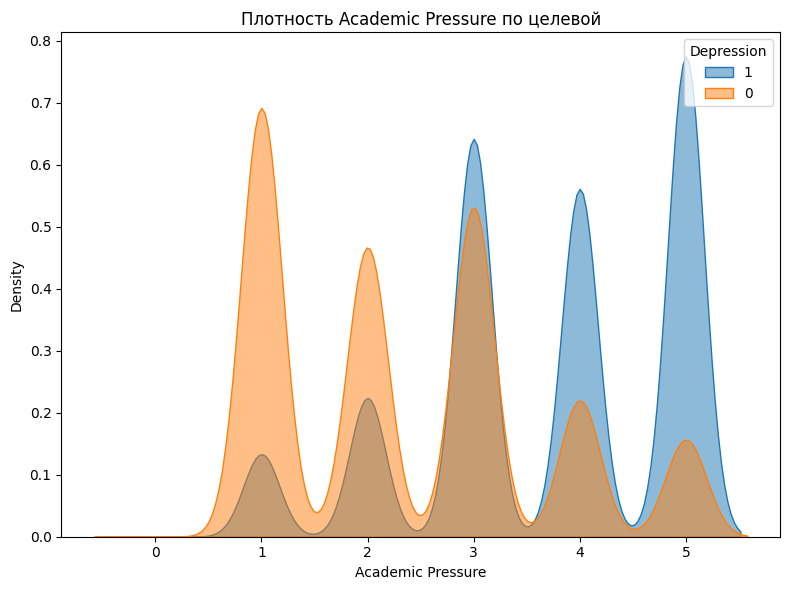

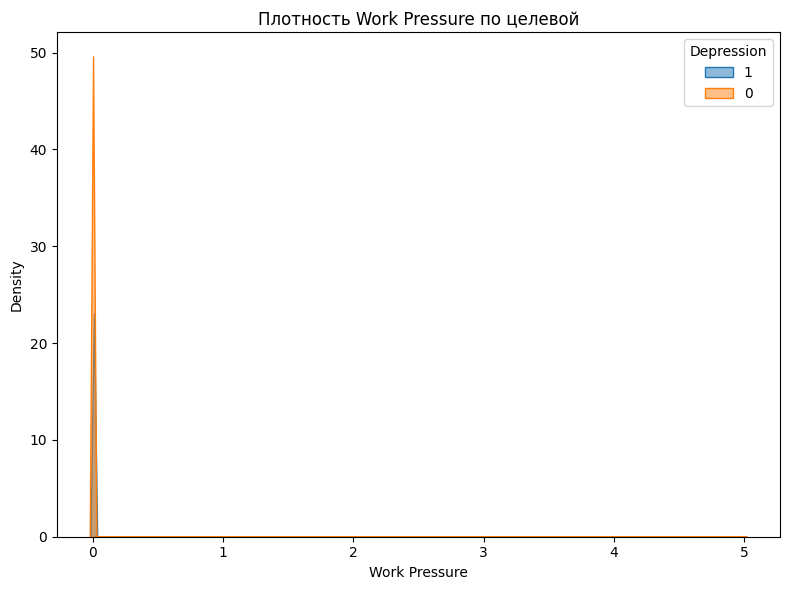

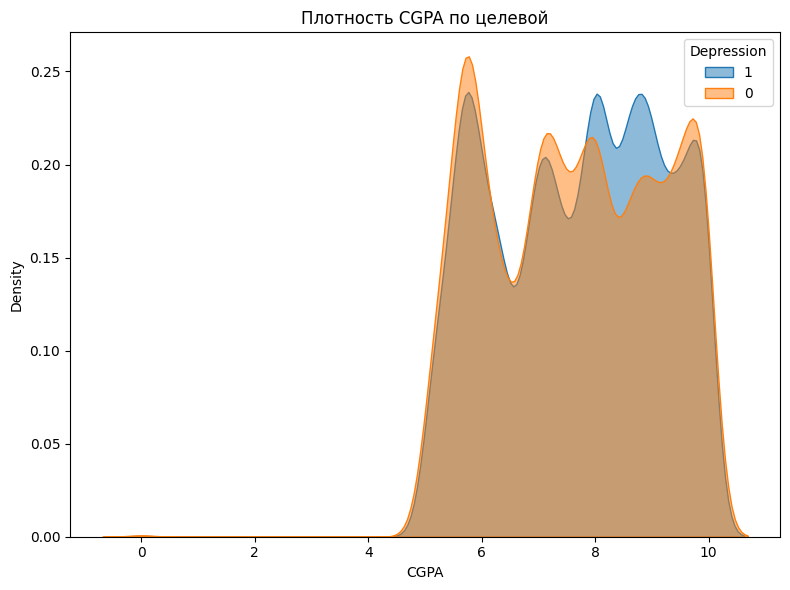

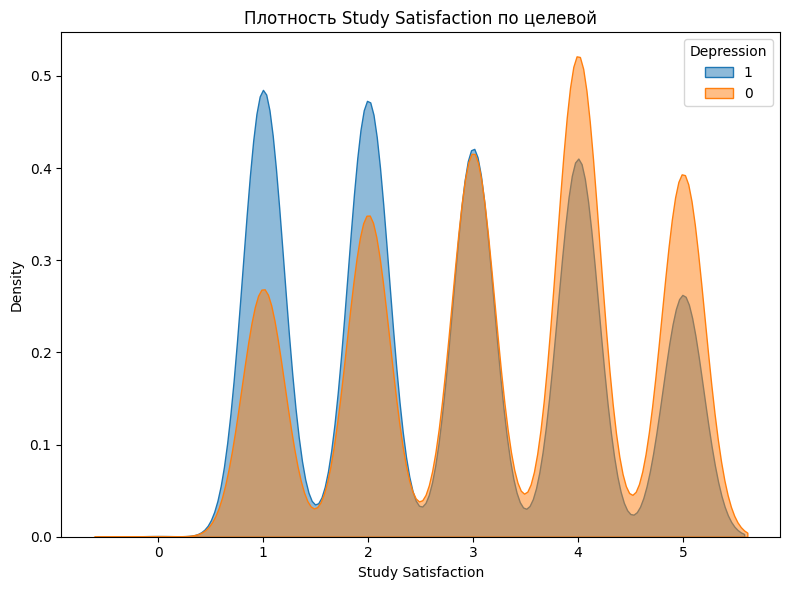

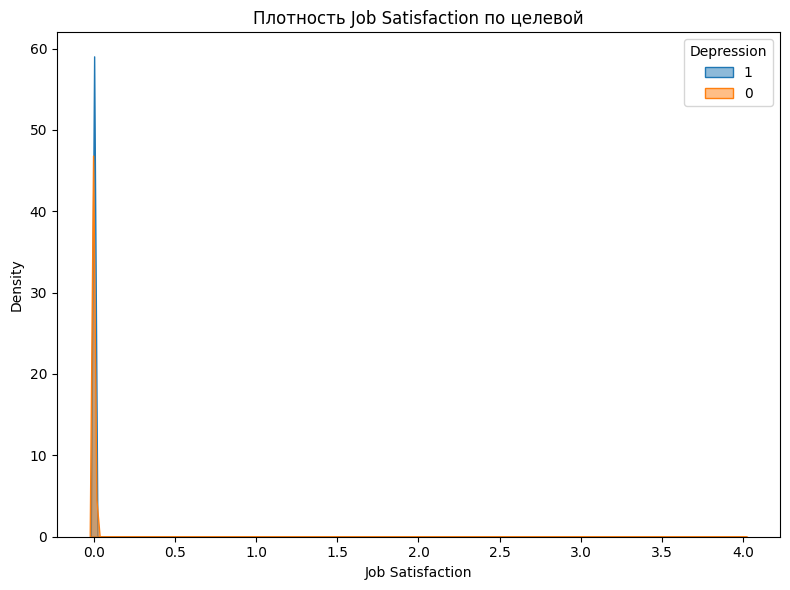

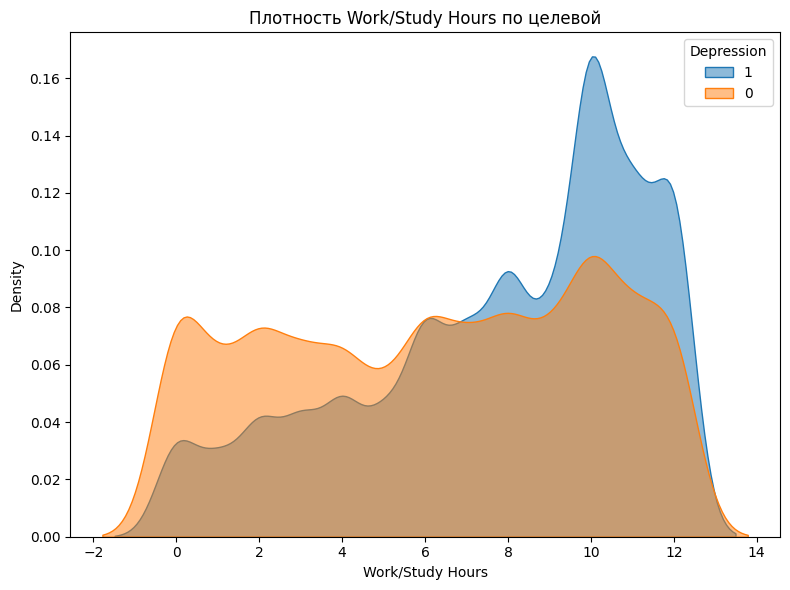

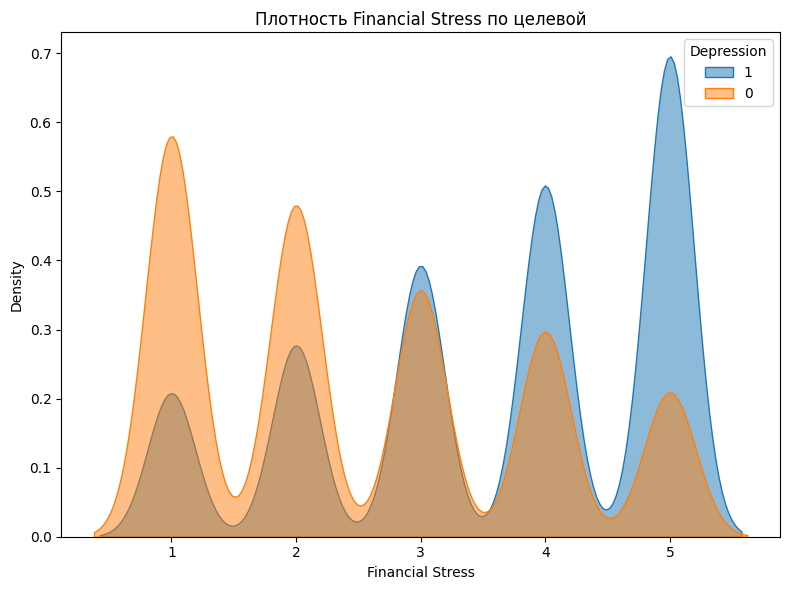

In [15]:
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    for category in data[target_column].unique():
        sns.kdeplot(data[data[target_column] == category][column], label=f'{category}', fill=True, alpha=0.5)
    plt.title(f'Плотность {column} по целевой')
    plt.legend(title=target_column)
    plt.tight_layout()
    plt.show()


## 2.4 Связь категориальных столбцов с целевой переменной

In [16]:
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']

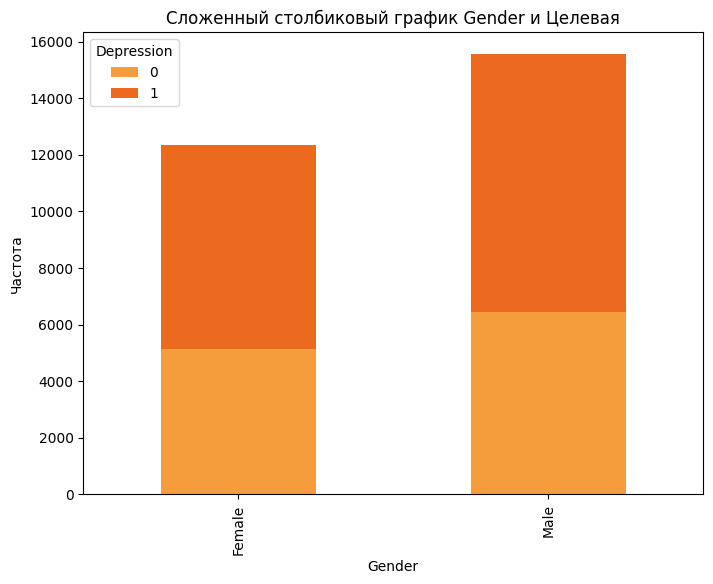

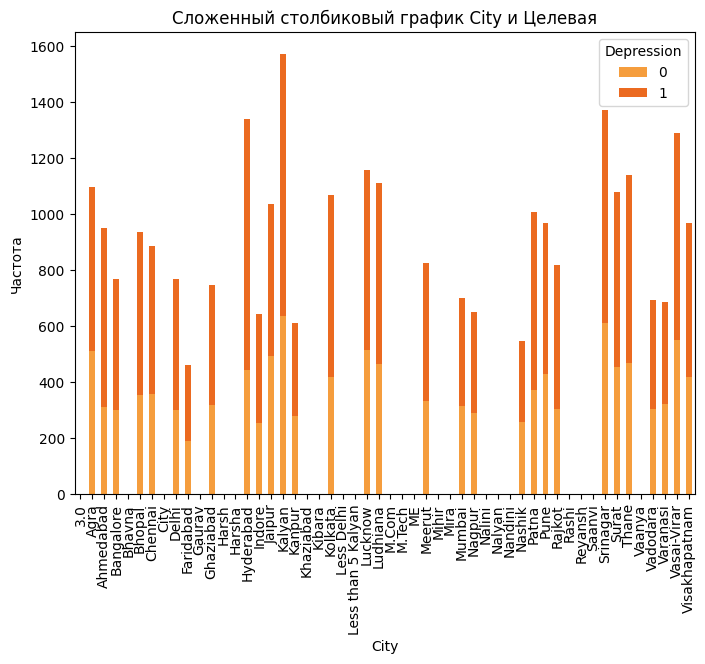

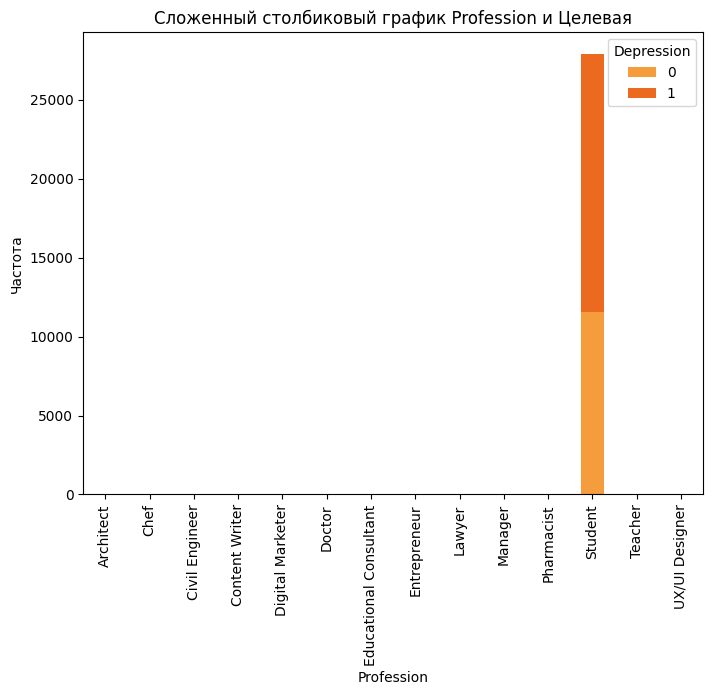

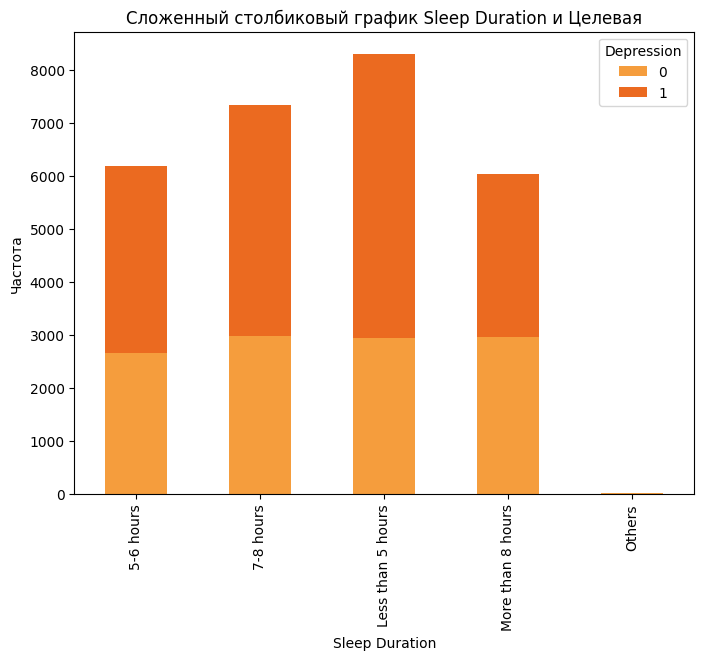

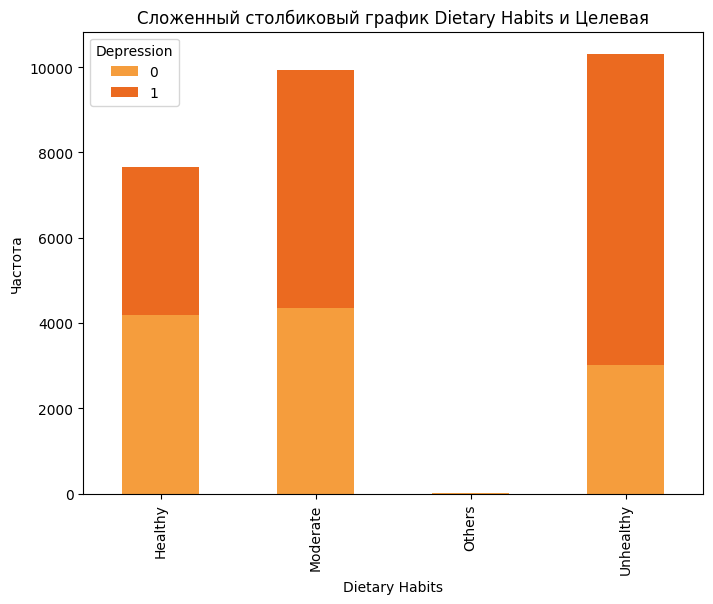

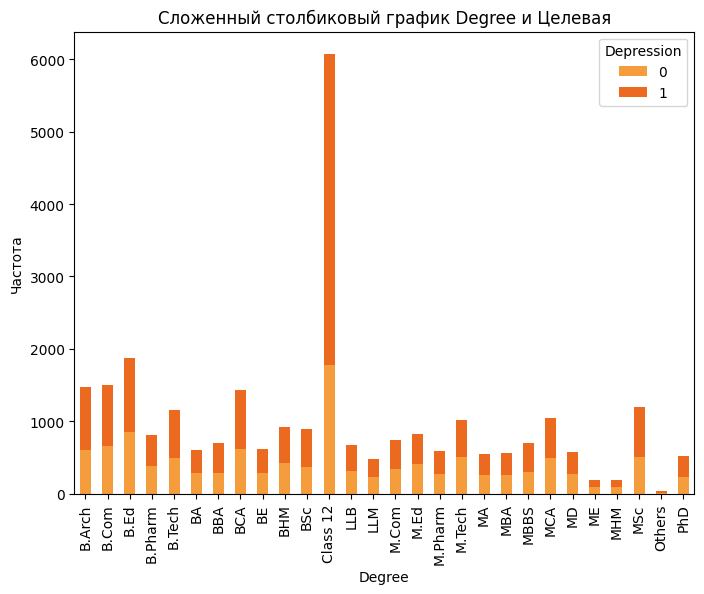

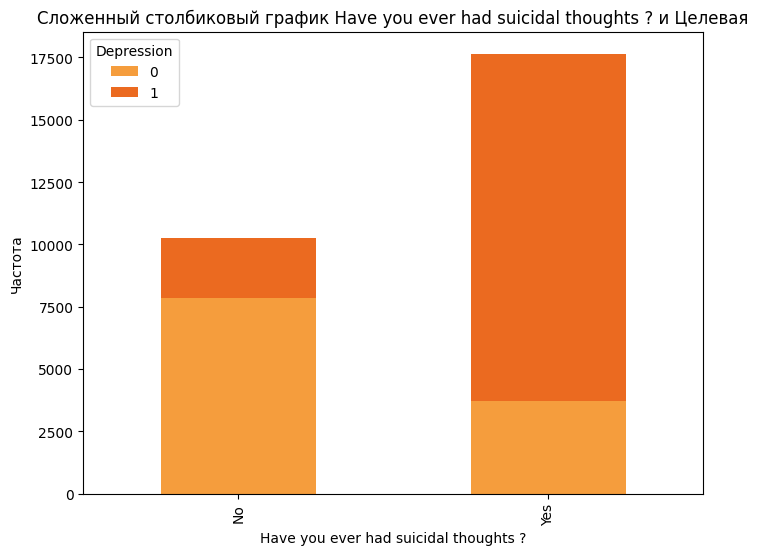

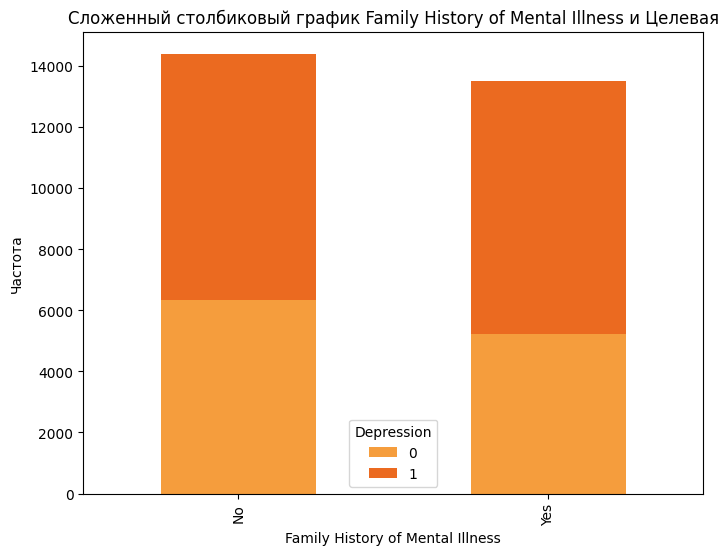

In [17]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#f59d3d','#eb6a20'])

# Пройдём по каждому категориальному столбцу в нашем списке
for column in categorical_columns:
    # Сложенный столбик
    pd.crosstab(data[column], data[target_column]).plot(kind='bar', stacked=True, colormap=cmap, figsize=(8, 6))
    plt.title(f"Сложенный столбиковый график {column} и Целевая")
    plt.xlabel(column)
    plt.ylabel("Частота")
    plt.show()

## 2.5 Изучение профессий

In [18]:
value_counts = data['Profession'].value_counts()
value_counts

,count
Profession,
Student,27870
Architect,8
Teacher,6
Digital Marketer,3
Content Writer,2
Chef,2
Doctor,2
Pharmacist,2
Civil Engineer,1


## 2.6 Изучение степеней (уровней) образования

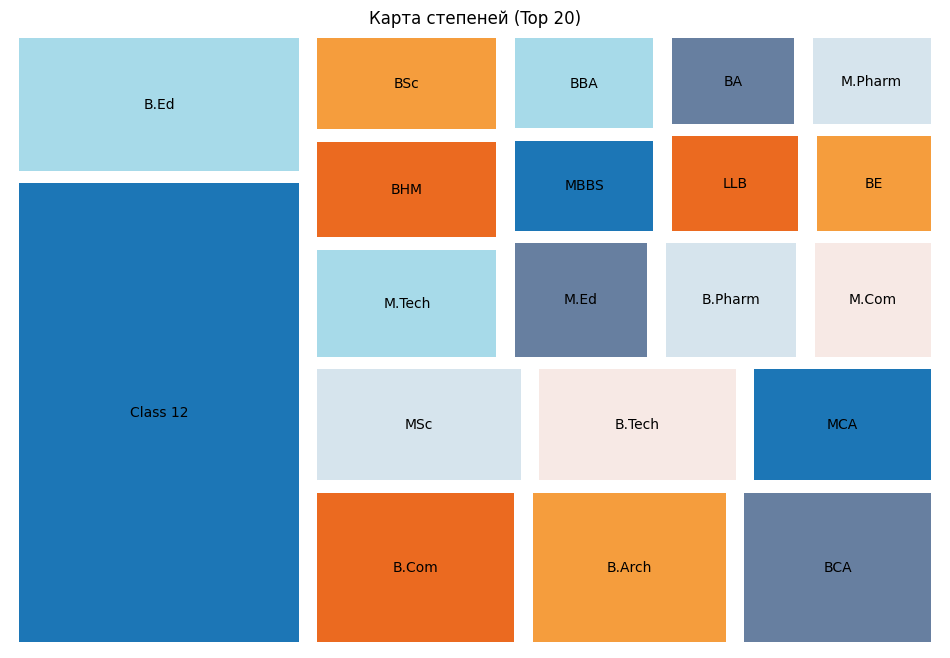

In [19]:
# Вычислите частоты
value_counts = data['Degree'].value_counts()
sizes = value_counts.values[:20]  # Показываем только 20 лучших для удобства чтения

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=value_counts.index[:20], color=colors, pad=True)
plt.title(f"Карта степеней (Top 20)")
plt.axis("off")
plt.show()

In [20]:
# Узнаем 10 самых распространенных степеней
top_professions = data['Degree'].value_counts().nlargest(10).index

# Отфильтруем кадр данных для 10 лучших степеней
filtered_df = data[data['Degree'].isin(top_professions)]

# Создадим новый DataFrame для агрегации
agg_data = filtered_df.groupby(['Degree', 'Depression']).size().reset_index(name='Count')

# Создадим диаграмму-солнечное сияние
fig = px.sunburst(agg_data,
                  path=['Degree', 'Depression'],
                  values='Count',
                  title='Диаграмма солнечное сияние с 10 лучшими Degree и Depression',
                  color='Count',
                  color_continuous_scale=px.colors.sequential.Oranges[:])

fig.show()

## 2.7 Распределение целевой переменной

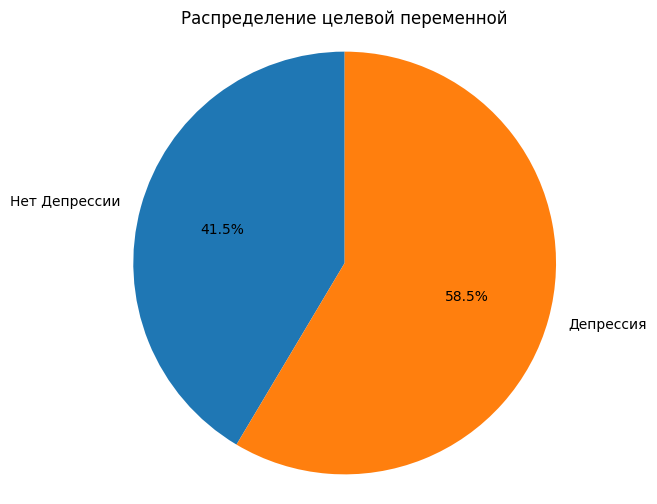

In [21]:
# Подсчитаем числовые значения для круговой диаграммы и добавим метки
class_counts = data[target_column].value_counts().sort_index()
labels = ["Нет Депрессии", "Депрессия"]
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels,
        autopct='%1.1f%%', startangle=90)
plt.title('Распределение целевой переменной')
plt.axis('equal')  # Равное соотношение сторон гарантирует, что круговая диаграмма будет отображаться в виде круга
plt.show()

## 2.8 Корреляция между переменными

In [50]:
# Рассчитаем корреляционную матрицу
correlation_matrix = data.corr(numeric_only=True)

# Создадим интерактивную тепловую карту с оранжевым и синим цветами
fig = px.imshow(correlation_matrix,
                text_auto=True,  # Отображение значений корреляции
                color_continuous_scale='RdYlBu',  # Цветовая гамма с оттенками красного, желтого и синего.
                title='Тепловая карта корреляционной матрицы',
                aspect='auto')

fig.show()

# 3. Feature Engineering and Data Preprocessing

## 3.1 Так как у нас мало данных по другим профессиям возьмем только студентов

In [28]:
data = data[data['Profession'] == 'Student'] # возьмём только студентов

## 3.2 Так как вы взяли только студентов тогда переименуем название колонки Work/Study Hours на Study Hours

In [29]:
data.rename(columns={'Work/Study Hours':'Study Hours'}, inplace=True)

## 3.3 Degree

In [30]:
data['Degree'].unique()

array(['B.Pharm', 'BSc', 'BA', 'BCA', 'M.Tech', 'PhD', 'Class 12', 'B.Ed',
       'LLB', 'BE', 'M.Ed', 'MSc', 'BHM', 'M.Pharm', 'MCA', 'MA', 'B.Com',
       'MD', 'MBA', 'MBBS', 'M.Com', 'B.Arch', 'LLM', 'B.Tech', 'BBA',
       'ME', 'MHM', 'Others'], dtype=object)

In [31]:
# Очищаем и классифицируем колонку "Degree"
def process_degree(value):
    degree_map = {
        'bachelor': [
            'bsc', 'b.sc', 'bpharm', 'b.pharm', 'h_pharm', 'btech', 'b.tech',
            'llb', 'll.ba', 'll.b', 'barch', 'b.arch', 'b.com', 'bca', 'a.ed',
            'bba', 'be', 'b.ed', 'bed', 'b.hm', 'bh', 'b.bca', 'b.ba', 'mbbs', 'b.press',
            'ba', 'bhm'
        ],
        'master': [
            'msc', 'm.sc', 'mtech', 'm.tech', 's.tech', 'mba', 'mhm',
            'm.business analyst', 'llm', 'll.com', 'mca', 'hca', 'm.ed',
            'm.com', 'm.pharm', 'm.arch', 'm.m.ed', 'm.ui', 'g.ed',
            'ma', 'me'
        ],
        'doctorate': ['phd', 'md', 'doctor'],
        'high_school': ['class 11', 'class 12']
    }

    if not isinstance(value, str):
        return np.nan

    value = value.strip().lower()
    for category, values in degree_map.items():
        if value in values:
            return category

    return np.nan

data['Degree'] = data['Degree'].apply(process_degree)

In [32]:
data['Degree'].value_counts()

,count
Degree,
bachelor,13319
master,7346
high_school,6080
doctorate,1090


## 3.4 City

In [33]:
data['City'].value_counts()

,count
City,
Kalyan,1564
Srinagar,1372
Hyderabad,1339
Vasai-Virar,1289
Lucknow,1155
Thane,1139
Ludhiana,1109
Agra,1092
Surat,1078


In [34]:
# Если город встречается в данных меньше 5 раз, он заменяется на 'OtherCity'
city_threshold = 5

city_counts = data['City'].value_counts()

data['City'] = data['City'].map(
    lambda x: x if pd.isna(x) or city_counts.get(x, 0) >= city_threshold else 'OtherCity'
)

In [35]:
data['City'].value_counts()

,count
City,
Kalyan,1564
Srinagar,1372
Hyderabad,1339
Vasai-Virar,1289
Lucknow,1155
Thane,1139
Ludhiana,1109
Agra,1092
Surat,1078


## 3.5 Уберем не нужные колонки связанные с работай. Наши студенты не работают, это было видно по графикам

In [36]:
data.drop(columns=['Profession', 'Work Pressure', 'Job Satisfaction'], inplace=True)

## 3.6 Преобразование категориального типа данных признака в категорию

In [37]:
categorical_features = [ col for col in data.columns if data[col].dtype in ['object', 'bool', 'category', 'uint8'] and col != 'Depression']

# изменим тип данных на категорию
for col in categorical_features:
    data[col] = data[col].astype('category')


## 3.7 Заполнение пропущенных значений  
- Заполним числовые признаки с помощью knn-импутации.  
- Заполним категориальные признаки с помощью моды.  

In [38]:
data.isna().sum()

,0
Gender,0
Age,0
City,0
Academic Pressure,0
CGPA,0
Study Satisfaction,0
Sleep Duration,0
Dietary Habits,0
Degree,35
Have you ever had suicidal thoughts ?,0


In [39]:
categorical_features = [ col for col in data.columns if data[col].dtype in ['object', 'bool', 'category', 'uint8'] and col != 'Depression']
numerical_features = [ col for col in data.columns if data[col].dtype in ['int64', 'float64'] and col != 'Depression']

print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

Numerical features: ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Study Hours', 'Financial Stress']
Categorical features: ['Gender', 'City', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


In [40]:
# Заполним недостающие значения с помощью knn-импутера
num_imputer_knn = KNNImputer(n_neighbors=3)

data[numerical_features] = num_imputer_knn.fit_transform(data[numerical_features])

# заполним недостающие значения других признаков с помощью моды
data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

print(f'Отсутствующие значения в наборе данных:\n {data.isnull().sum()}')

Отсутствующие значения в наборе данных:
 Gender                                   0
Age                                      0
City                                     0
Academic Pressure                        0
CGPA                                     0
Study Satisfaction                       0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Study Hours                              0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64


## 3.8 Feature Scaling and Encoding
Мы подготавливаем данные для моделирования следующим образом:

- Масштабирование *числовых* признаков: Используем **StandardScaler** для стандартизации числовых признаков, чтобы они имели среднее значение 0 и стандартное отклонение 1. Это важно для алгоритмов, чувствительных к масштабу признаков.

- Кодирование *категориальных* признаков: Применяем **OneHotEncoder** для преобразования категориальных переменных в бинарную матрицу. Этот метод аккуратно обрабатывает неизвестные категории, игнорируя их, и исключает один уровень, если признак бинарный, чтобы избежать мультиколлинеарности.

In [41]:
print(f'Числовые характеристики: {numerical_features}')
print(f'Категориальные признаки: {categorical_features}')

Числовые характеристики: ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Study Hours', 'Financial Stress']
Категориальные признаки: ['Gender', 'City', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


In [42]:
# Масштабирование числовых признаков
scaler = StandardScaler()

# One-hot encoding для категориальных признаков
encoder = OneHotEncoder(handle_unknown='ignore', return_df=True)

## 3.9 Data splitting

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
# Разделим данные на признаки(X) и целевой (y)
X = data.drop(columns='Depression')
y = data['Depression']

# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создаем отдельные массивы для числовых и категориальных признаков
X_train_num = X_train[numerical_features]
X_test_num = X_test[numerical_features]

X_train_cat = X_train[categorical_features]
X_test_cat = X_test[categorical_features]

# Масштабирование числовых признаков
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# One-hot encoding для категориальных признаков
X_train_cat_encoded = encoder.fit_transform(X_train_cat)  # Теперь сразу получаем плотную матрицу
X_test_cat_encoded = encoder.transform(X_test_cat)

# Объединяем преобразованные числовые и категориальные признаки
X_train = np.hstack((X_train_num_scaled, X_train_cat_encoded))
X_test = np.hstack((X_test_num_scaled, X_test_cat_encoded))

# Проверим распределение классов (0 и 1)
print("Первоначальное распределение классов:", y.value_counts(normalize=True))
print("Распределение классов обучающего набора:", y_train.value_counts(normalize=True))
print("Распределение классов в тестовом наборе:", y_test.value_counts(normalize=True))

Первоначальное распределение классов: Depression
1    0.585145
0    0.414855
Name: proportion, dtype: float64
Распределение классов обучающего набора: Depression
1    0.585127
0    0.414873
Name: proportion, dtype: float64
Распределение классов в тестовом наборе: Depression
1    0.585217
0    0.414783
Name: proportion, dtype: float64


# 4. Выбор и настройка моделей
Подготовив данные, мы приступаем к выбору и обучению различных моделей машинного обучения. Это включает в себя сравнительный анализ различных классификаторов, настройку их гиперпараметров и оценку их производительности, чтобы определить наиболее эффективную модель для нашей задачи прогнозирования.

## 4.1 Выбор модели и настройка гиперпараметров

Мы определили набор из 3 надежных классификаторов:  

1.   Логистическая регрессия
2.   Случайный лес
3.   XGBoost

Для каждой модели мы задаем сетку гиперпараметров и используем GridSearchCV с 5-кратной кросс-валидацией для определения оптимальных параметров, которые максимизируют ROC AUC. Показатели производительности, включая Accuracy и AUC, записываются для сравнения.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd

# Определение моделей и сеток параметров
models_with_params = {
    "Logistic Regression": (LogisticRegression(random_state=42, max_iter=1000), {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2']
    }),
    "Random Forest": (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 150],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    "XGBoost": (XGBClassifier(random_state=42, eval_metric='logloss'), {
        'n_estimators': [75, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [2, 3, 5],
        'subsample': [0.4, 0.6, 0.8],
    })
}

# Функция для настройки гиперпараметров и оценки модели
def tune_and_evaluate_model(model_name, model, params, X_train, y_train, X_test, y_test):
    # Perform GridSearchCV
    search = GridSearchCV(model, params, scoring='roc_auc', cv=5, n_jobs=-1)
    search.fit(X_train, y_train)

    # Получение наилучшей модели
    best_model = search.best_estimator_

    # Делаем прогнозы на тестовой выборке
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Рассчитать показатели производительности
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    return {"Model": model_name, "Accuracy": accuracy, "AUC": auc, "Best Params": search.best_params_}

results = []

# Итерация моделей и их настройка/оценка
for name, (model, params) in models_with_params.items():
    result = tune_and_evaluate_model(name, model, params, X_train, y_train, X_test, y_test)
    results.append(result)

results_df = pd.DataFrame(results)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



In [46]:
results_df

,Model,Accuracy,AUC,Best Params
0,Logistic Regression,0.847686,0.921601,"{'C': 0.1, 'penalty': 'l2'}"
1,Random Forest,0.839792,0.917206,"{'max_depth': 20, 'min_samples_split': 10, 'n_..."
2,XGBoost,0.850556,0.923200,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."


In [47]:
xgb_best_params = results_df[results_df['Model'] == 'XGBoost']['Best Params'].iloc[0]

In [48]:
xgb_best_params

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150, 'subsample': 0.4}

Наилучшая модель - XGBoost